## Setup

In [0]:
# The code in this cell is only necessary when using Google Colab and storing 
# the data on Google Drive. If you don't use that combination, ignore it.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import applications, optimizers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold
from hyperopt import hp, fmin, tpe, space_eval, tpe, Trials
from os import listdir
import pickle

In [0]:
# Replace this path with the path to the directory you want to save the files 
# produced by this notebook in.
notebook_dir = '/content/drive/My Drive/Colab Notebooks/3classes/pretrained/BA_CNN_Pretrained_Xception_Hyperparameteroptimization/'

# Replace these paths with the paths to the directories with your training 
# and testing data respectively.
# Each of the two directories should have three subdirectories named 'matrix',
# 'notype' and 'unpacking' with each subdirectory containing the images of the
# respective class.
train_data_dir = '/content/drive/My Drive/data3/train/'
test_data_dir = '/content/drive/My Drive/data3/validation/'

k_folds = 10
batch_size = 10
sample_array_length = 300
test_sample_array_length = 30

## Computing and Saving Feature Arrays

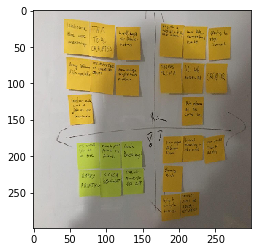

(299, 299, 3)
[1 0 0]
ndarray
ndarray


In [0]:
img_width, img_height = 299, 299

# loading datasets directly into memory beforehand - about 20 times faster when training
samples_x = []
samples_y = []
test_x = []
test_y = []

def add_class_from_dir(class_dir, label, data_x, data_y):
  class_samples = listdir(class_dir)
  for image in class_samples:
    img = load_img(path=class_dir + image, target_size=(img_height, img_width))
    data_x.append(img_to_array(img))
    data_y.append(label)

add_class_from_dir(class_dir=train_data_dir + 'matrix/', label=[1,0,0], data_x=samples_x, data_y=samples_y)
add_class_from_dir(class_dir=train_data_dir + 'notype/', label=[0,1,0], data_x=samples_x, data_y=samples_y)
add_class_from_dir(class_dir=train_data_dir + 'unpacking/', label=[0,0,1], data_x=samples_x, data_y=samples_y)

add_class_from_dir(class_dir=test_data_dir + 'matrix/', label=[1,0,0], data_x=test_x, data_y=test_y)
add_class_from_dir(class_dir=test_data_dir + 'notype/', label=[0,1,0], data_x=test_x, data_y=test_y)
add_class_from_dir(class_dir=test_data_dir + 'unpacking/', label=[0,0,1], data_x=test_x, data_y=test_y)

samples_x = np.array(samples_x)
test_x = np.array(test_x)
samples_y = np.array(samples_y)
test_y = np.array(test_y)

plt.figure()
plt.imshow(samples_x[0]/(255))
plt.show()
print(samples_x[0].shape)
print(samples_y[0])
print(type(samples_x).__name__)
print(type(test_x).__name__)

assert sample_array_length == len(samples_x)
assert test_sample_array_length == len(test_x)

In [0]:
datagen = ImageDataGenerator(rescale=1. / 255)

# build the Xception network
model = applications.Xception(include_top=False, weights='imagenet')

generator = datagen.flow(
    samples_x,
    samples_y,
    batch_size=batch_size,
    shuffle=False)
bottleneck_features_train = model.predict_generator(
    generator, len(samples_x) // batch_size)
with open(notebook_dir + 'bottleneck_features_train.npy', 'wb') as features_train_file:
    np.save(features_train_file, bottleneck_features_train)

generator = datagen.flow(
    test_x,
    test_y,
    batch_size=batch_size,
    shuffle=False)
bottleneck_features_validation = model.predict_generator(
    generator, len(test_x) // batch_size)
with open(notebook_dir + 'bottleneck_features_test.npy', 'wb') as validation_features_file:
    np.save(validation_features_file, bottleneck_features_validation)
    
keras.backend.clear_session()

print('features extracted and saved')

W0809 10:45:08.151259 139776420812672 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


83689472/83683744 [==============================] - 4s 0us/step
features extracted and saved


## Hyperparameter Optimization

### Load feature arrays, objective function and hyperparameter searchspace

In [0]:
# load feature arrays from files
train_data = np.load(open(notebook_dir + 'bottleneck_features_train.npy', 'rb'))
train_labels = np.array(
    [0] * (sample_array_length // 3) + [1] * (sample_array_length // 3) + [2] * (sample_array_length // 3))
train_labels = to_categorical(train_labels)
test_data = np.load(open(notebook_dir + 'bottleneck_features_test.npy', 'rb'))
test_labels = np.array(
    [0] * (test_sample_array_length // 3) + [1] * (test_sample_array_length // 3) + [2] * (test_sample_array_length // 3))
test_labels = to_categorical(test_labels)

print('feature arrays loaded')

feature arrays loaded


In [0]:
# define the function to be optimized
def evaluate_model(args):
  print(args)
    
  # build, train and cross validate k models
  cross_validation_results = []
  skf = StratifiedKFold(n_splits=k_folds, random_state=4, shuffle=True)
  current_split = 0
  for train_index, val_index in skf.split(train_data, list(map(lambda x: np.argmax(x), train_labels))):

    train_x, train_y = train_data[train_index], train_labels[train_index]
    val_x, val_y = train_data[val_index], train_labels[val_index]
    
    # set the learning rate for the optimizer
    optimizer = keras.optimizers.get(args['optimizer'])
    keras.backend.set_value(optimizer.lr, args['learning_rate'])

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    for i in range(int(args['number_of_dense_layers'])):
      model.add(Dense(int(args['dense_neurons']), activation='relu'))
      model.add(Dropout(args['dropout']))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer=optimizer,
                  loss=args['loss_func'], metrics=['accuracy'])

    model.fit(train_x, train_y,
              epochs=int(args['epochs']),
              batch_size=int(args['batch_size']),
              validation_data=(val_x, val_y),
              verbose=0)

    result = model.evaluate(val_x, val_y, verbose=0)
    cross_validation_results.append(result)

    current_split += 1

    keras.backend.clear_session()
    del model
  # print mean of validation results
  mean_val_acc = np.mean(list(map(lambda x: x[1], cross_validation_results)))
  print('cross validation result: ' + str(mean_val_acc))
  print('############################################################################################################################')
  return -mean_val_acc

In [0]:
# define the hyperparameter searchspace
hyperparameter_space = {
    'optimizer': hp.choice('optimizer', ['rmsprop',
                                         'sgd',
                                         'adagrad',
                                         'adadelta',
                                         'adam',
                                         'nadam']),
    'dropout': hp.quniform('dropout', 0.0, 0.9, 0.1),
    'epochs': hp.quniform('epochs', 1, 100, 5),
    'batch_size': hp.quniform('batch_size', 1, 300, 1),
    'loss_func': hp.choice('loss_func', ['categorical_crossentropy',
                                         'mean_squared_error',
                                         'mean_absolute_error',
                                         'mean_absolute_percentage_error',
                                         'mean_squared_logarithmic_error',
                                         'categorical_hinge',
                                         'logcosh',
                                         'kullback_leibler_divergence',
                                         'poisson',
                                         'cosine_proximity']),
    'dense_neurons': hp.quniform('dense_neurons', 16, 500, 1),
    'number_of_dense_layers': hp.quniform('number_of_dense_layers', 1, 5, 1),
    'learning_rate': hp.uniform('learning_rate', 0.00001, 0.1)
}

### evals 0 - 100 (done)

In [0]:
# since colab shuts down after 6-12 hours I will repeatedly run the 
# optimization using the trials object to store the results in betweenn runs

trials = Trials()

# optimize hyperparameters using TPE for 100 evaluation cycles
best_model = fmin(evaluate_model,
                  hyperparameter_space,
                  algo=tpe.suggest,
                  trials=trials,
                  max_evals=100)

pickle.dump(trials, open(notebook_dir + 'trials.p', 'wb'))
print('saved trials to file')
print(space_eval(hyperparameter_space, best_model))

{'batch_size': 141.0, 'dense_neurons': 168.0, 'dropout': 0.1, 'epochs': 70.0, 'learning_rate': 0.07273946312651051, 'loss_func': 'mean_squared_error', 'number_of_dense_layers': 4.0, 'optimizer': 'rmsprop'}
  0%|          | 0/100 [00:00<?, ?it/s, best loss: ?]


W0819 15:55:31.347555 140138753984384 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


cross validation result: 0.3333333
############################################################################################################################
{'batch_size': 90.0, 'dense_neurons': 470.0, 'dropout': 0.6000000000000001, 'epochs': 45.0, 'learning_rate': 0.06745800479973331, 'loss_func': 'mean_absolute_error', 'number_of_dense_layers': 2.0, 'optimizer': 'rmsprop'}
  1%|          | 1/100 [02:41<4:26:47, 161.69s/it, best loss: -0.3333333134651184]

W0819 15:58:09.999444 140138753984384 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0819 15:58:10.037148 140138753984384 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0819 15:58:24.861944 140138753984384 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0819 15:58:24.899532 140138753984384 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0819 15:58:39.137151 140138753984384 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


cross validation result: 0.35
############################################################################################################################
{'batch_size': 184.0, 'dense_neurons': 494.0, 'dropout': 0.8, 'epochs': 50.0, 'learning_rate': 0.02056993082278568, 'loss_func': 'mean_absolute_error', 'number_of_dense_layers': 2.0, 'optimizer': 'rmsprop'}
cross validation result: 0.3333333
############################################################################################################################
{'batch_size': 263.0, 'dense_neurons': 108.0, 'dropout': 0.5, 'epochs': 10.0, 'learning_rate': 0.0810133360075025, 'loss_func': 'poisson', 'number_of_dense_layers': 2.0, 'optimizer': 'sgd'}
cross validation result: 0.40333334
############################################################################################################################
{'batch_size': 203.0, 'dense_neurons': 411.0, 'dropout': 0.1, 'epochs': 90.0, 'learning_rate': 0.09718081528243601, 'loss_func'

W0819 16:03:14.450330 140138753984384 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


cross validation result: 0.3333333
############################################################################################################################
{'batch_size': 286.0, 'dense_neurons': 101.0, 'dropout': 0.9, 'epochs': 85.0, 'learning_rate': 0.05727298398289432, 'loss_func': 'categorical_hinge', 'number_of_dense_layers': 2.0, 'optimizer': 'adadelta'}
cross validation result: 0.49
############################################################################################################################
{'batch_size': 201.0, 'dense_neurons': 430.0, 'dropout': 0.2, 'epochs': 50.0, 'learning_rate': 0.059354996032676625, 'loss_func': 'categorical_crossentropy', 'number_of_dense_layers': 1.0, 'optimizer': 'nadam'}
cross validation result: 0.69
############################################################################################################################
{'batch_size': 260.0, 'dense_neurons': 169.0, 'dropout': 0.5, 'epochs': 90.0, 'learning_rate': 0.0240797514906821

W0819 16:12:06.271464 140138753984384 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/optimizer_v2/adagrad.py:105: calling Constant.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


cross validation result: 0.35333332
############################################################################################################################
{'batch_size': 17.0, 'dense_neurons': 477.0, 'dropout': 0.8, 'epochs': 70.0, 'learning_rate': 0.05822028753505094, 'loss_func': 'mean_squared_error', 'number_of_dense_layers': 5.0, 'optimizer': 'adagrad'}
cross validation result: 0.3333333
############################################################################################################################
{'batch_size': 36.0, 'dense_neurons': 288.0, 'dropout': 0.30000000000000004, 'epochs': 40.0, 'learning_rate': 0.04799922820638311, 'loss_func': 'mean_absolute_error', 'number_of_dense_layers': 2.0, 'optimizer': 'adadelta'}
cross validation result: 0.77
############################################################################################################################
{'batch_size': 73.0, 'dense_neurons': 238.0, 'dropout': 0.2, 'epochs': 35.0, 'learning_rate': 0.

### evals 101 - 200 (done)

In [0]:
trials = pickle.load(open(notebook_dir + 'trials.p', 'rb'))

best_model = fmin(evaluate_model,
                  hyperparameter_space,
                  algo=tpe.suggest,
                  trials=trials,
                  max_evals=200)

pickle.dump(trials, open(notebook_dir + 'trials.p', 'wb'))
print('saved trials to file')
print(space_eval(hyperparameter_space, best_model))

{'batch_size': 190.0, 'dense_neurons': 222.0, 'dropout': 0.30000000000000004, 'epochs': 30.0, 'learning_rate': 0.059676733830425294, 'loss_func': 'cosine_proximity', 'number_of_dense_layers': 3.0, 'optimizer': 'sgd'}
  0%|          | 0/100 [00:00<?, ?it/s, best loss: ?]


W0819 21:12:03.618618 140656457860992 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0819 21:12:03.914439 140656457860992 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


cross validation result: 0.116666675
############################################################################################################################
{'batch_size': 203.0, 'dense_neurons': 266.0, 'dropout': 0.5, 'epochs': 40.0, 'learning_rate': 0.09990383099901008, 'loss_func': 'logcosh', 'number_of_dense_layers': 4.0, 'optimizer': 'adam'}
cross validation result: 0.3333333
############################################################################################################################
{'batch_size': 156.0, 'dense_neurons': 365.0, 'dropout': 0.2, 'epochs': 65.0, 'learning_rate': 0.06543395769150936, 'loss_func': 'mean_squared_logarithmic_error', 'number_of_dense_layers': 5.0, 'optimizer': 'sgd'}
cross validation result: 0.77333325
############################################################################################################################
{'batch_size': 81.0, 'dense_neurons': 419.0, 'dropout': 0.1, 'epochs': 85.0, 'learning_rate': 0.084125250155943

W0819 21:17:51.136683 140656457860992 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/optimizer_v2/adagrad.py:105: calling Constant.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


cross validation result: 0.3333333
############################################################################################################################
{'batch_size': 213.0, 'dense_neurons': 92.0, 'dropout': 0.0, 'epochs': 95.0, 'learning_rate': 0.028532239340268717, 'loss_func': 'mean_absolute_error', 'number_of_dense_layers': 3.0, 'optimizer': 'sgd'}
cross validation result: 0.7633333
############################################################################################################################
{'batch_size': 222.0, 'dense_neurons': 497.0, 'dropout': 0.0, 'epochs': 80.0, 'learning_rate': 0.04539455377811617, 'loss_func': 'poisson', 'number_of_dense_layers': 1.0, 'optimizer': 'nadam'}
cross validation result: 0.35999998
############################################################################################################################
{'batch_size': 106.0, 'dense_neurons': 274.0, 'dropout': 0.2, 'epochs': 25.0, 'learning_rate': 0.09060660364158354, 'loss_f

W0819 21:34:49.491616 140656457860992 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0819 21:34:49.542321 140656457860992 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0819 21:34:49.590490 140656457860992 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0819 21:34:52.766330 140656457860992 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0819 21:34:52.815663 140656457860992 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


cross validation result: 0.34666666
############################################################################################################################
{'batch_size': 129.0, 'dense_neurons': 328.0, 'dropout': 0.1, 'epochs': 70.0, 'learning_rate': 0.07462763224096437, 'loss_func': 'categorical_hinge', 'number_of_dense_layers': 4.0, 'optimizer': 'sgd'}
cross validation result: 0.62
############################################################################################################################
{'batch_size': 116.0, 'dense_neurons': 456.0, 'dropout': 0.4, 'epochs': 55.0, 'learning_rate': 0.09723522755037106, 'loss_func': 'mean_squared_logarithmic_error', 'number_of_dense_layers': 3.0, 'optimizer': 'adadelta'}
cross validation result: 0.78000003
############################################################################################################################
{'batch_size': 49.0, 'dense_neurons': 349.0, 'dropout': 0.9, 'epochs': 40.0, 'learning_rate': 0.0126072

### evals 201-300 (done)

In [0]:
trials = pickle.load(open(notebook_dir + 'trials.p', 'rb'))

best_model = fmin(evaluate_model,
                  hyperparameter_space,
                  algo=tpe.suggest,
                  trials=trials,
                  max_evals=300)

pickle.dump(trials, open(notebook_dir + 'trials.p', 'wb'))
print('saved trials to file')
print(space_eval(hyperparameter_space, best_model))

{'batch_size': 216.0, 'dense_neurons': 271.0, 'dropout': 0.0, 'epochs': 0.0, 'learning_rate': 0.06051697880800334, 'loss_func': 'logcosh', 'number_of_dense_layers': 2.0, 'optimizer': 'sgd'}
  0%|          | 0/100 [00:00<?, ?it/s, best loss: ?]


W0820 16:30:58.648436 140585428338560 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


cross validation result: 0.34
############################################################################################################################
{'batch_size': 246.0, 'dense_neurons': 131.0, 'dropout': 0.2, 'epochs': 60.0, 'learning_rate': 0.05601583478289398, 'loss_func': 'mean_squared_error', 'number_of_dense_layers': 5.0, 'optimizer': 'adagrad'}
  1%|          | 1/100 [00:10<17:28, 10.60s/it, best loss: -0.7833333611488342]

W0820 16:31:06.501514 140585428338560 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/optimizer_v2/adagrad.py:105: calling Constant.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


cross validation result: 0.3333333
############################################################################################################################
{'batch_size': 138.0, 'dense_neurons': 431.0, 'dropout': 0.0, 'epochs': 85.0, 'learning_rate': 0.08523688293095756, 'loss_func': 'logcosh', 'number_of_dense_layers': 2.0, 'optimizer': 'sgd'}
cross validation result: 0.7733334
############################################################################################################################
{'batch_size': 174.0, 'dense_neurons': 163.0, 'dropout': 0.1, 'epochs': 65.0, 'learning_rate': 0.049669533143047395, 'loss_func': 'cosine_proximity', 'number_of_dense_layers': 3.0, 'optimizer': 'nadam'}
  3%|▎         | 3/100 [06:35<2:53:13, 107.15s/it, best loss: -0.7833333611488342]

W0820 16:37:31.402564 140585428338560 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


cross validation result: 0.3333333
############################################################################################################################
{'batch_size': 192.0, 'dense_neurons': 321.0, 'dropout': 0.1, 'epochs': 90.0, 'learning_rate': 0.08228323843630361, 'loss_func': 'logcosh', 'number_of_dense_layers': 2.0, 'optimizer': 'sgd'}
cross validation result: 0.77
############################################################################################################################
{'batch_size': 199.0, 'dense_neurons': 256.0, 'dropout': 0.0, 'epochs': 95.0, 'learning_rate': 0.06787742515792988, 'loss_func': 'logcosh', 'number_of_dense_layers': 2.0, 'optimizer': 'rmsprop'}
cross validation result: 0.34333333
############################################################################################################################
{'batch_size': 258.0, 'dense_neurons': 246.0, 'dropout': 0.0, 'epochs': 100.0, 'learning_rate': 0.06533395530124186, 'loss_func': 'logcosh

W0820 17:42:11.073195 140585428338560 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0820 17:42:11.144201 140585428338560 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0820 17:42:11.198011 140585428338560 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0820 17:42:26.340406 140585428338560 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0820 17:42:26.395754 140585428338560 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


cross validation result: 0.3333333
############################################################################################################################
{'batch_size': 251.0, 'dense_neurons': 323.0, 'dropout': 0.1, 'epochs': 50.0, 'learning_rate': 0.08261289508124824, 'loss_func': 'logcosh', 'number_of_dense_layers': 3.0, 'optimizer': 'sgd'}
cross validation result: 0.79333335
############################################################################################################################
{'batch_size': 157.0, 'dense_neurons': 342.0, 'dropout': 0.1, 'epochs': 50.0, 'learning_rate': 0.08726484238931305, 'loss_func': 'logcosh', 'number_of_dense_layers': 1.0, 'optimizer': 'sgd'}
cross validation result: 0.77
############################################################################################################################
{'batch_size': 292.0, 'dense_neurons': 324.0, 'dropout': 0.0, 'epochs': 35.0, 'learning_rate': 0.08147500223997456, 'loss_func': 'logcosh', 'n

### evals 301-400 (done)

In [0]:
trials = pickle.load(open(notebook_dir + 'trials.p', 'rb'))

best_model = fmin(evaluate_model,
                  hyperparameter_space,
                  algo=tpe.suggest,
                  trials=trials,
                  max_evals=400)

pickle.dump(trials, open(notebook_dir + 'trials.p', 'wb'))
print('saved trials to file')
print(space_eval(hyperparameter_space, best_model))

{'batch_size': 240.0, 'dense_neurons': 266.0, 'dropout': 0.6000000000000001, 'epochs': 35.0, 'learning_rate': 0.04987724162443803, 'loss_func': 'mean_absolute_percentage_error', 'number_of_dense_layers': 3.0, 'optimizer': 'adadelta'}
  0%|          | 0/100 [00:00<?, ?it/s, best loss: ?]


W0820 21:46:30.831728 140306899748736 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0820 21:46:30.871876 140306899748736 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0820 21:46:30.922055 140306899748736 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0820 21:46:30.968984 140306899748736 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0820 21:46:41.947666 1403

cross validation result: 0.7
############################################################################################################################
{'batch_size': 247.0, 'dense_neurons': 197.0, 'dropout': 0.5, 'epochs': 5.0, 'learning_rate': 0.05898682284728104, 'loss_func': 'categorical_hinge', 'number_of_dense_layers': 3.0, 'optimizer': 'sgd'}
  1%|          | 1/100 [01:42<2:48:31, 102.13s/it, best loss: -0.7933333516120911]

W0820 21:48:10.060422 140306899748736 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


cross validation result: 0.3633333
############################################################################################################################
{'batch_size': 192.0, 'dense_neurons': 462.0, 'dropout': 0.0, 'epochs': 85.0, 'learning_rate': 0.04238140952650019, 'loss_func': 'kullback_leibler_divergence', 'number_of_dense_layers': 2.0, 'optimizer': 'sgd'}
cross validation result: 0.3333333
############################################################################################################################
{'batch_size': 139.0, 'dense_neurons': 317.0, 'dropout': 0.30000000000000004, 'epochs': 50.0, 'learning_rate': 0.09992422918612966, 'loss_func': 'logcosh', 'number_of_dense_layers': 1.0, 'optimizer': 'adagrad'}
  3%|▎         | 3/100 [05:30<3:08:39, 116.70s/it, best loss: -0.7933333516120911]

W0820 21:51:58.068563 140306899748736 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/optimizer_v2/adagrad.py:105: calling Constant.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


cross validation result: 0.36333334
############################################################################################################################
{'batch_size': 106.0, 'dense_neurons': 70.0, 'dropout': 0.8, 'epochs': 95.0, 'learning_rate': 0.0457986925848382, 'loss_func': 'mean_squared_logarithmic_error', 'number_of_dense_layers': 2.0, 'optimizer': 'nadam'}
cross validation result: 0.3
############################################################################################################################
{'batch_size': 182.0, 'dense_neurons': 346.0, 'dropout': 0.0, 'epochs': 55.0, 'learning_rate': 0.07437598331432309, 'loss_func': 'logcosh', 'number_of_dense_layers': 3.0, 'optimizer': 'sgd'}
cross validation result: 0.7733333
############################################################################################################################
{'batch_size': 196.0, 'dense_neurons': 405.0, 'dropout': 0.1, 'epochs': 65.0, 'learning_rate': 0.029877554535315543, 'lo

### evals 401-500 (done)

In [0]:
trials = pickle.load(open(notebook_dir + 'trials.p', 'rb'))

best_model = fmin(evaluate_model,
                  hyperparameter_space,
                  algo=tpe.suggest,
                  trials=trials,
                  max_evals=500)

pickle.dump(trials, open(notebook_dir + 'trials.p', 'wb'))
print('saved trials to file')
print(space_eval(hyperparameter_space, best_model))

{'batch_size': 155.0, 'dense_neurons': 289.0, 'dropout': 0.2, 'epochs': 80.0, 'learning_rate': 0.09990701457670847, 'loss_func': 'logcosh', 'number_of_dense_layers': 5.0, 'optimizer': 'adagrad'}
cross validation result: 0.3333333
############################################################################################################################
{'batch_size': 182.0, 'dense_neurons': 374.0, 'dropout': 0.0, 'epochs': 55.0, 'learning_rate': 0.07453175788679968, 'loss_func': 'logcosh', 'number_of_dense_layers': 3.0, 'optimizer': 'sgd'}
cross validation result: 0.77666664
############################################################################################################################
{'batch_size': 201.0, 'dense_neurons': 407.0, 'dropout': 0.0, 'epochs': 65.0, 'learning_rate': 0.035529321602936384, 'loss_func': 'mean_squared_logarithmic_error', 'number_of_dense_layers': 4.0, 'optimizer': 'sgd'}
cross validation result: 0.7633333
###########################################

### evals 501-600 (done)

In [0]:
trials = pickle.load(open(notebook_dir + 'trials.p', 'rb'))

best_model = fmin(evaluate_model,
                  hyperparameter_space,
                  algo=tpe.suggest,
                  trials=trials,
                  max_evals=600)

pickle.dump(trials, open(notebook_dir + 'trials.p', 'wb'))
print('saved trials to file')
print(space_eval(hyperparameter_space, best_model))

{'batch_size': 207.0, 'dense_neurons': 380.0, 'dropout': 0.1, 'epochs': 60.0, 'learning_rate': 0.0735662669663651, 'loss_func': 'mean_absolute_error', 'number_of_dense_layers': 3.0, 'optimizer': 'nadam'}
  0%|          | 0/100 [00:00<?, ?it/s, best loss: ?]


W0822 09:18:54.514822 139822745048960 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


cross validation result: 0.3333333
############################################################################################################################
{'batch_size': 138.0, 'dense_neurons': 285.0, 'dropout': 0.0, 'epochs': 70.0, 'learning_rate': 0.0829079423246701, 'loss_func': 'logcosh', 'number_of_dense_layers': 3.0, 'optimizer': 'sgd'}
cross validation result: 0.75666666
############################################################################################################################
{'batch_size': 198.0, 'dense_neurons': 366.0, 'dropout': 0.0, 'epochs': 50.0, 'learning_rate': 0.09292383418062988, 'loss_func': 'mean_squared_error', 'number_of_dense_layers': 2.0, 'optimizer': 'sgd'}
cross validation result: 0.7033333
############################################################################################################################
{'batch_size': 252.0, 'dense_neurons': 296.0, 'dropout': 0.2, 'epochs': 60.0, 'learning_rate': 0.08559983986724445, 'loss_func'

W0822 09:35:29.326258 139822745048960 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


cross validation result: 0.75
############################################################################################################################
{'batch_size': 237.0, 'dense_neurons': 318.0, 'dropout': 0.0, 'epochs': 50.0, 'learning_rate': 0.06311768004514844, 'loss_func': 'logcosh', 'number_of_dense_layers': 2.0, 'optimizer': 'sgd'}
cross validation result: 0.75999993
############################################################################################################################
{'batch_size': 146.0, 'dense_neurons': 374.0, 'dropout': 0.30000000000000004, 'epochs': 35.0, 'learning_rate': 0.08145490046253803, 'loss_func': 'kullback_leibler_divergence', 'number_of_dense_layers': 3.0, 'optimizer': 'adagrad'}
  8%|▊         | 8/100 [20:55<3:43:54, 146.03s/it, best loss: -0.7933333516120911]

W0822 09:39:47.248617 139822745048960 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/optimizer_v2/adagrad.py:105: calling Constant.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


cross validation result: 0.3333333
############################################################################################################################
{'batch_size': 212.0, 'dense_neurons': 408.0, 'dropout': 0.1, 'epochs': 30.0, 'learning_rate': 0.08716956851198612, 'loss_func': 'logcosh', 'number_of_dense_layers': 3.0, 'optimizer': 'sgd'}
cross validation result: 0.7633333
############################################################################################################################
{'batch_size': 170.0, 'dense_neurons': 385.0, 'dropout': 0.2, 'epochs': 60.0, 'learning_rate': 0.06823897776175636, 'loss_func': 'categorical_crossentropy', 'number_of_dense_layers': 4.0, 'optimizer': 'sgd'}
cross validation result: 0.7566666
############################################################################################################################
{'batch_size': 189.0, 'dense_neurons': 455.0, 'dropout': 0.0, 'epochs': 45.0, 'learning_rate': 0.09535985148252057, 'loss

W0822 10:28:16.082867 139822745048960 nn_ops.py:4224] Large dropout rate: 0.8 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0822 10:28:16.133978 139822745048960 nn_ops.py:4224] Large dropout rate: 0.8 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0822 10:28:16.177494 139822745048960 nn_ops.py:4224] Large dropout rate: 0.8 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0822 10:28:16.221211 139822745048960 nn_ops.py:4224] Large dropout rate: 0.8 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0822 10:28:32.548416 139822745048960 nn_ops.py:4224] Large dropout rate: 0.8 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


cross validation result: 0.32999998
############################################################################################################################
{'batch_size': 235.0, 'dense_neurons': 300.0, 'dropout': 0.30000000000000004, 'epochs': 60.0, 'learning_rate': 0.06117087944461247, 'loss_func': 'poisson', 'number_of_dense_layers': 3.0, 'optimizer': 'adam'}
cross validation result: 0.3333333
############################################################################################################################
{'batch_size': 213.0, 'dense_neurons': 350.0, 'dropout': 0.0, 'epochs': 65.0, 'learning_rate': 0.08234320621464, 'loss_func': 'logcosh', 'number_of_dense_layers': 3.0, 'optimizer': 'sgd'}
cross validation result: 0.75999993
############################################################################################################################
{'batch_size': 248.0, 'dense_neurons': 332.0, 'dropout': 0.0, 'epochs': 55.0, 'learning_rate': 0.07887760748068133, 'loss_

### evals 601-700 (done)

In [0]:
trials = pickle.load(open(notebook_dir + 'trials.p', 'rb'))

best_model = fmin(evaluate_model,
                  hyperparameter_space,
                  algo=tpe.suggest,
                  trials=trials,
                  max_evals=700)

pickle.dump(trials, open(notebook_dir + 'trials.p', 'wb'))
print('saved trials to file')
print(space_eval(hyperparameter_space, best_model))

{'batch_size': 189.0, 'dense_neurons': 332.0, 'dropout': 0.1, 'epochs': 50.0, 'learning_rate': 0.06551746245682093, 'loss_func': 'mean_absolute_percentage_error', 'number_of_dense_layers': 3.0, 'optimizer': 'sgd'}
cross validation result: 0.3333333
############################################################################################################################
{'batch_size': 171.0, 'dense_neurons': 440.0, 'dropout': 0.0, 'epochs': 60.0, 'learning_rate': 0.06987445856033651, 'loss_func': 'logcosh', 'number_of_dense_layers': 3.0, 'optimizer': 'sgd'}
cross validation result: 0.7666666
############################################################################################################################
{'batch_size': 206.0, 'dense_neurons': 388.0, 'dropout': 0.0, 'epochs': 40.0, 'learning_rate': 0.07992139548090078, 'loss_func': 'logcosh', 'number_of_dense_layers': 3.0, 'optimizer': 'nadam'}
cross validation result: 0.3333333
###############################################

### evals 701-800 (done)

In [0]:
trials = pickle.load(open(notebook_dir + 'trials.p', 'rb'))

best_model = fmin(evaluate_model,
                  hyperparameter_space,
                  algo=tpe.suggest,
                  trials=trials,
                  max_evals=800)

pickle.dump(trials, open(notebook_dir + 'trials.p', 'wb'))
print('saved trials to file')
print(space_eval(hyperparameter_space, best_model))

{'batch_size': 216.0, 'dense_neurons': 314.0, 'dropout': 0.30000000000000004, 'epochs': 65.0, 'learning_rate': 0.08347893513313141, 'loss_func': 'cosine_proximity', 'number_of_dense_layers': 4.0, 'optimizer': 'sgd'}
  0%|          | 0/100 [00:00<?, ?it/s, best loss: ?]


W0822 18:43:30.496382 140184235669376 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0822 18:43:30.832376 140184235669376 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


cross validation result: 0.113333344
############################################################################################################################
{'batch_size': 245.0, 'dense_neurons': 215.0, 'dropout': 0.1, 'epochs': 70.0, 'learning_rate': 0.08634007432307202, 'loss_func': 'mean_absolute_error', 'number_of_dense_layers': 3.0, 'optimizer': 'adam'}
cross validation result: 0.3333333
############################################################################################################################
{'batch_size': 173.0, 'dense_neurons': 285.0, 'dropout': 0.1, 'epochs': 55.0, 'learning_rate': 0.06964779066888367, 'loss_func': 'logcosh', 'number_of_dense_layers': 2.0, 'optimizer': 'sgd'}
cross validation result: 0.7633333
############################################################################################################################
{'batch_size': 279.0, 'dense_neurons': 327.0, 'dropout': 0.1, 'epochs': 65.0, 'learning_rate': 0.08212163991983107, 'loss_f

W0822 18:51:12.859740 140184235669376 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/optimizer_v2/adagrad.py:105: calling Constant.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


cross validation result: 0.3333333
############################################################################################################################
{'batch_size': 149.0, 'dense_neurons': 339.0, 'dropout': 0.2, 'epochs': 75.0, 'learning_rate': 0.07316092158319462, 'loss_func': 'poisson', 'number_of_dense_layers': 3.0, 'optimizer': 'sgd'}
cross validation result: 0.77666664
############################################################################################################################
{'batch_size': 184.0, 'dense_neurons': 194.0, 'dropout': 0.0, 'epochs': 85.0, 'learning_rate': 0.0802737610900889, 'loss_func': 'logcosh', 'number_of_dense_layers': 4.0, 'optimizer': 'adadelta'}
cross validation result: 0.7633333
############################################################################################################################
{'batch_size': 164.0, 'dense_neurons': 276.0, 'dropout': 0.1, 'epochs': 50.0, 'learning_rate': 0.0625204974394864, 'loss_func': 'mean

W0822 19:47:27.711322 140184235669376 nn_ops.py:4224] Large dropout rate: 0.9 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0822 19:47:27.766163 140184235669376 nn_ops.py:4224] Large dropout rate: 0.9 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0822 19:47:27.816993 140184235669376 nn_ops.py:4224] Large dropout rate: 0.9 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0822 19:47:27.867926 140184235669376 nn_ops.py:4224] Large dropout rate: 0.9 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0822 19:47:58.303684 140184235669376 nn_ops.py:4224] Large dropout rate: 0.9 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


cross validation result: 0.34333333
############################################################################################################################
{'batch_size': 218.0, 'dense_neurons': 326.0, 'dropout': 0.1, 'epochs': 65.0, 'learning_rate': 0.08562513706709358, 'loss_func': 'mean_squared_logarithmic_error', 'number_of_dense_layers': 3.0, 'optimizer': 'sgd'}
cross validation result: 0.77
############################################################################################################################
{'batch_size': 168.0, 'dense_neurons': 286.0, 'dropout': 0.0, 'epochs': 60.0, 'learning_rate': 0.07981710576822176, 'loss_func': 'logcosh', 'number_of_dense_layers': 5.0, 'optimizer': 'sgd'}
cross validation result: 0.77
############################################################################################################################
{'batch_size': 265.0, 'dense_neurons': 362.0, 'dropout': 0.1, 'epochs': 55.0, 'learning_rate': 0.08979320073285608, 'loss_fu

### evals 801-900 (done)

In [0]:
trials = pickle.load(open(notebook_dir + 'trials.p', 'rb'))

best_model = fmin(evaluate_model,
                  hyperparameter_space,
                  algo=tpe.suggest,
                  trials=trials,
                  max_evals=900)

pickle.dump(trials, open(notebook_dir + 'trials.p', 'wb'))
print('saved trials to file')
print(space_eval(hyperparameter_space, best_model))

{'batch_size': 186.0, 'dense_neurons': 365.0, 'dropout': 0.0, 'epochs': 65.0, 'learning_rate': 0.08617247768526255, 'loss_func': 'logcosh', 'number_of_dense_layers': 3.0, 'optimizer': 'sgd'}
cross validation result: 0.75999993
############################################################################################################################
{'batch_size': 207.0, 'dense_neurons': 396.0, 'dropout': 0.0, 'epochs': 60.0, 'learning_rate': 0.08865377660467924, 'loss_func': 'logcosh', 'number_of_dense_layers': 3.0, 'optimizer': 'sgd'}
cross validation result: 0.7666666
############################################################################################################################
{'batch_size': 237.0, 'dense_neurons': 377.0, 'dropout': 0.0, 'epochs': 55.0, 'learning_rate': 0.08351653351383263, 'loss_func': 'logcosh', 'number_of_dense_layers': 3.0, 'optimizer': 'sgd'}
cross validation result: 0.77333325
######################################################################

### evals 901-1000 (done)

In [0]:
trials = pickle.load(open(notebook_dir + 'trials.p', 'rb'))

best_model = fmin(evaluate_model,
                  hyperparameter_space,
                  algo=tpe.suggest,
                  trials=trials,
                  max_evals=1000)

pickle.dump(trials, open(notebook_dir + 'trials.p', 'wb'))
print('saved trials to file')
print(space_eval(hyperparameter_space, best_model))

{'batch_size': 190.0, 'dense_neurons': 212.0, 'dropout': 0.2, 'epochs': 50.0, 'learning_rate': 0.08198158145983597, 'loss_func': 'mean_absolute_error', 'number_of_dense_layers': 3.0, 'optimizer': 'nadam'}
  0%|          | 0/100 [00:00<?, ?it/s, best loss: ?]


W0829 18:32:16.667783 139834881570688 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


cross validation result: 0.3333333
############################################################################################################################
{'batch_size': 179.0, 'dense_neurons': 348.0, 'dropout': 0.0, 'epochs': 40.0, 'learning_rate': 0.07067641927878102, 'loss_func': 'logcosh', 'number_of_dense_layers': 3.0, 'optimizer': 'sgd'}
cross validation result: 0.7633333
############################################################################################################################
{'batch_size': 209.0, 'dense_neurons': 370.0, 'dropout': 0.0, 'epochs': 65.0, 'learning_rate': 0.08866759643869287, 'loss_func': 'logcosh', 'number_of_dense_layers': 2.0, 'optimizer': 'sgd'}
cross validation result: 0.78
############################################################################################################################
{'batch_size': 152.0, 'dense_neurons': 315.0, 'dropout': 0.0, 'epochs': 80.0, 'learning_rate': 0.07350681310594935, 'loss_func': 'logcosh', 'nu

W0829 18:53:49.814528 139834881570688 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


cross validation result: 0.78
############################################################################################################################
{'batch_size': 217.0, 'dense_neurons': 360.0, 'dropout': 0.1, 'epochs': 65.0, 'learning_rate': 0.09983553005513485, 'loss_func': 'categorical_hinge', 'number_of_dense_layers': 4.0, 'optimizer': 'sgd'}
cross validation result: 0.71999997
############################################################################################################################
{'batch_size': 9.0, 'dense_neurons': 448.0, 'dropout': 0.0, 'epochs': 50.0, 'learning_rate': 0.07681244077738027, 'loss_func': 'kullback_leibler_divergence', 'number_of_dense_layers': 3.0, 'optimizer': 'sgd'}
cross validation result: 0.3333333
############################################################################################################################
{'batch_size': 203.0, 'dense_neurons': 390.0, 'dropout': 0.0, 'epochs': 60.0, 'learning_rate': 0.08770321156833924

W0829 19:06:11.637439 139834881570688 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/optimizer_v2/adagrad.py:105: calling Constant.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


cross validation result: 0.3333333
############################################################################################################################
{'batch_size': 195.0, 'dense_neurons': 428.0, 'dropout': 0.1, 'epochs': 40.0, 'learning_rate': 0.06706240977499309, 'loss_func': 'categorical_crossentropy', 'number_of_dense_layers': 3.0, 'optimizer': 'adadelta'}
cross validation result: 0.7533333
############################################################################################################################
{'batch_size': 183.0, 'dense_neurons': 348.0, 'dropout': 0.0, 'epochs': 65.0, 'learning_rate': 0.04523380118055286, 'loss_func': 'logcosh', 'number_of_dense_layers': 2.0, 'optimizer': 'sgd'}
cross validation result: 0.77
############################################################################################################################
{'batch_size': 138.0, 'dense_neurons': 415.0, 'dropout': 0.8, 'epochs': 55.0, 'learning_rate': 0.08418509057894673, 'loss

W0829 19:14:15.849518 139834881570688 nn_ops.py:4224] Large dropout rate: 0.8 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0829 19:14:15.892547 139834881570688 nn_ops.py:4224] Large dropout rate: 0.8 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0829 19:14:15.934440 139834881570688 nn_ops.py:4224] Large dropout rate: 0.8 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0829 19:14:40.955429 139834881570688 nn_ops.py:4224] Large dropout rate: 0.8 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0829 19:14:40.999458 139834881570688 nn_ops.py:4224] Large dropout rate: 0.8 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


cross validation result: 0.35
############################################################################################################################
{'batch_size': 184.0, 'dense_neurons': 304.0, 'dropout': 0.0, 'epochs': 45.0, 'learning_rate': 0.075178534632702, 'loss_func': 'logcosh', 'number_of_dense_layers': 4.0, 'optimizer': 'sgd'}
cross validation result: 0.77
############################################################################################################################
{'batch_size': 126.0, 'dense_neurons': 331.0, 'dropout': 0.1, 'epochs': 70.0, 'learning_rate': 0.09196768551279379, 'loss_func': 'logcosh', 'number_of_dense_layers': 3.0, 'optimizer': 'sgd'}
cross validation result: 0.75666666
############################################################################################################################
{'batch_size': 168.0, 'dense_neurons': 226.0, 'dropout': 0.30000000000000004, 'epochs': 50.0, 'learning_rate': 0.06127405900264174, 'loss_func': 'cos